<a href="https://colab.research.google.com/github/surya-varathan/Tweet-Classification/blob/master/CoronaTweetsNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Information Classification from Social Media during an epidemic

#Import Libraries 

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nltk

# Natural Language Processing
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from nltk.corpus import stopwords

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Data Cleaning function


In [0]:
def clean_data(dataframe):

    # Drop duplicate rows
    dataframe.drop_duplicates(subset='tweet', inplace=True)
    
    # Drop Null entries
    dataframe.dropna(inplace=True)

    # Transform all text to lowercase
    dataframe['tweet'] = dataframe['tweet'].str.lower()
    
    # Remove punctation
    dataframe['tweet'] = dataframe['tweet'].str.replace('[^\w\s]',' ')

    # Remove numbers 
    dataframe['tweet'] = dataframe['tweet'].str.replace('[^A-Za-z]',' ')

    # Make sure any double-spaces are single 
    dataframe['tweet'] = dataframe['tweet'].str.replace('  ',' ')
    dataframe['tweet'] = dataframe['tweet'].str.replace('  ',' ')

    return dataframe

##Importing data and cleaning

In [0]:
df = pd.read_csv('TweetsDataset.csv')
clean_data(df)
df.drop(columns=['id'], inplace = True)
print("Data shape: ",df.shape)
print(df['label'].value_counts())

Data shape:  (921, 2)
Irrelevant    427
Report        285
Awareness     137
Treatment      72
Name: label, dtype: int64


###Upsampling for the lowest two classes
 

In [0]:
from sklearn.utils import resample
df_treatment = df[df['label']=='Treatment']
df_awareness = df[df['label']=='Awareness']
df_others = df[df['label']!='Treatment']
df_upsampled_t = resample(df_treatment,replace = True,n_samples = 250, random_state=42)
df_upsampled_a = resample(df_awareness,replace = True,n_samples = 220, random_state=42)
df = pd.concat([df_others,df_upsampled_t,df_upsampled_a])
print(df['label'].value_counts())

Irrelevant    427
Awareness     357
Report        285
Treatment     250
Name: label, dtype: int64


In [0]:
tweet = df['tweet'].str.cat(sep=' ')
tweet = tweet.lower()
tokens = word_tokenize(tweet)
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words and w.isalpha()]
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

['covid',
 'coronavirus',
 'people',
 'us',
 'cases',
 'new',
 'spread',
 'virus',
 'treatment',
 'health',
 'home',
 'today',
 'positive',
 'tested',
 'help',
 'need',
 'days',
 'stay',
 'time',
 'patients',
 'remdesivir',
 'test',
 'get',
 'breaking',
 'take',
 'one',
 'please',
 'pandemic',
 'testing',
 'trump',
 'symptoms',
 'news',
 'like',
 'social',
 'first',
 'coronavirusoutbreak',
 'must',
 'protect',
 'everyone',
 'public',
 'vaccine',
 'fight',
 'cure',
 'emergency',
 'medical',
 'china',
 'trial',
 'support',
 'pm',
 'show']

###A visual representation of the vocabulary scaled to frequency

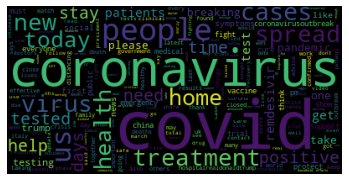

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Customised Bar Plot Function

In [0]:
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g = sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

Changing the tag notation from string to numeric

In [0]:
 my_tags = ['Awareness', 'Irrelevant', 'Report', 'Treatment']
Encoder = LabelEncoder()
df['label'] = Encoder.fit_transform(df['label'])
print(df['label'].unique())
name_mapping = dict(zip(Encoder.classes_, Encoder.transform(Encoder.classes_)))
print(name_mapping)


[0 1 2 3]
{'Awareness': 0, 'Irrelevant': 1, 'Report': 2, 'Treatment': 3}


# Natural Language Processing (NLP)

###Using Count Vectorizer  explore the most used words and combinations of words from each category 

###**Ngram Range = (1,1)**

*   For the Awareness label

In [0]:
mask_no = df['label'] == 0
awareness_tweets = df[mask_no]['tweet']

# Instantiate a CountVectorizer = CountVectorizer(stop_words = 'english')
cv_awareness = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec_awareness = cv_awareness.fit_transform(awareness_tweets)

# Convert into a DataFrame
cvec_awareness_df = pd.DataFrame(cvec_awareness.toarray(),columns=cv_awareness.get_feature_names())

# Inspect head 
print(cvec_awareness_df.shape) 

(357, 1228)


*    For the report label




In [0]:
mask_no = df['label'] == 2
report_tweets = df[mask_no]['tweet']

# Instantiate a CountVectorizer
cv_report = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec_report = cv_report.fit_transform(report_tweets)

# Convert into a DataFrame
cvec_report_df = pd.DataFrame(cvec_report.toarray(),
                   columns=cv_report.get_feature_names())

# Inspect head 
print(cvec_report_df.shape)

(285, 2335)



*   For the Treatment label



In [0]:
mask_no = df['label'] == 3
treatment_tweets = df[mask_no]['tweet']

# Instantiate a CountVectorizer
cv_treatment = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec_treatment = cv_treatment.fit_transform(treatment_tweets)

# Convert into a DataFrame
cvec_treatment_df = pd.DataFrame(cvec_treatment.toarray(),
                   columns=cv_treatment.get_feature_names())

# Inspect head 
print(cvec_treatment_df.shape)

(250, 811)



*   For the Irrelevant label



In [0]:
mask_no = df['label'] == 1
irrelevant_tweets = df[mask_no]['tweet']

# Instantiate a CountVectorizer
cv_irrelevant = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec_irrelevant = cv_irrelevant.fit_transform(irrelevant_tweets)

# Convert into a DataFrame
cvec_irrelevant_df = pd.DataFrame(cvec_irrelevant.toarray(),
                   columns=cv_irrelevant.get_feature_names())

# Inspect head 
print(cvec_irrelevant_df.shape)

(427, 3198)


## Set up variables to figure out top 10 unigrams in Each label

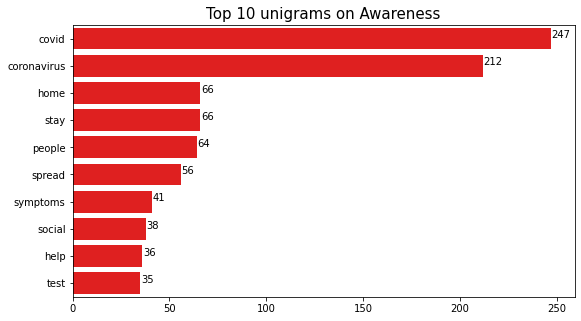

In [0]:
#Awareness Label
wc_A = cvec_awareness_df.sum(axis = 0)
awareness_top10 = wc_A.sort_values(ascending=False).head(10)
bar_plot(awareness_top10.values, awareness_top10.index, 'Top 10 unigrams on Awareness','r') 

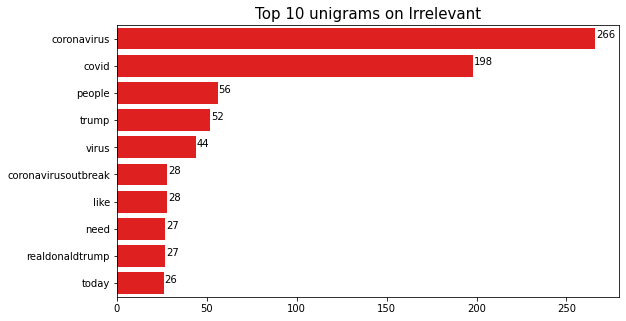

In [0]:
#Irrelevant Label
wc_I = cvec_irrelevant_df.sum(axis = 0)
irrelevant_top10 = wc_I.sort_values(ascending=False).head(10)
bar_plot(irrelevant_top10.values, irrelevant_top10.index, 'Top 10 unigrams on Irrelevant','r')

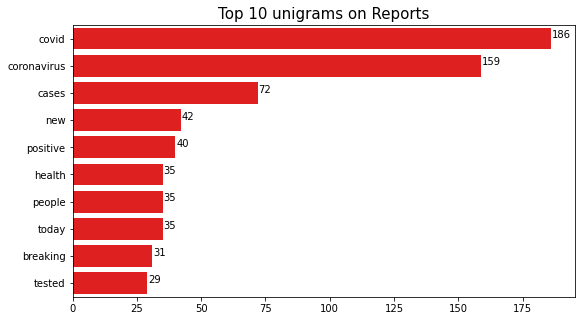

In [0]:
#Report Label
wc_R = cvec_report_df.sum(axis = 0)
report_top10 = wc_R.sort_values(ascending=False).head(10)
bar_plot(report_top10.values, report_top10.index, 'Top 10 unigrams on Reports','r')

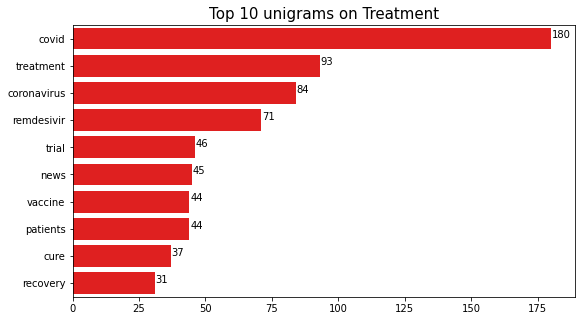

In [0]:
#Treatment Label
wc_T = cvec_treatment_df.sum(axis = 0)
treatment_top10 = wc_T.sort_values(ascending=False).head(10)
bar_plot(treatment_top10.values, treatment_top10.index, 'Top 10 unigrams on Treatment','r')

### Common Unigrams between Top 10 in each label

In [0]:
# Create list of unique words in top ten
awareness_set = set(awareness_top10.index)
irrelevant_set = set(irrelevant_top10.index)
report_set = set(report_top10.index)
treatment_set = set(treatment_top10.index)

# Return common words
common_unigrams = awareness_set.intersection(irrelevant_set.intersection(report_set.intersection(treatment_set)))
common_unigrams

{'coronavirus', 'covid'}

###**Ngram Range = (2,2)**

*  For the Awareness label

In [0]:
mask_on = df['label'] == 0
awareness_tweets = df[mask_on]['tweet']

# Instantiate a CountVectorizer
cv_awareness = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
cvec_awareness = cv_awareness.fit_transform(awareness_tweets)

# Convert into a DataFrame
cvec_awareness_df = pd.DataFrame(cvec_awareness.toarray(),
                   columns=cv_awareness.get_feature_names())

# Inspect head 
print(cvec_awareness_df.shape) 

(357, 2070)



*  For the Irrelevant label


In [0]:
mask_no = df['label'] == 1
irrelevant_tweets = df[mask_no]['tweet']

# Instantiate a CountVectorizer
cv_irrelevant = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
cvec_irrelevant = cv_irrelevant.fit_transform(irrelevant_tweets)

# Convert into a DataFrame
cvec_irrelevant_df = pd.DataFrame(cvec_irrelevant.toarray(),
                   columns=cv_irrelevant.get_feature_names())

# Inspect head 
print(cvec_irrelevant_df.shape)


(427, 5867)



*  For the Report label


In [0]:
mask_no = df['label'] == 2
report_tweets = df[mask_no]['tweet']

# Instantiate a CountVectorizer
cv_report = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
cvec_report = cv_report.fit_transform(report_tweets)

# Convert into a DataFrame
cvec_report_df = pd.DataFrame(cvec_report.toarray(),
                   columns=cv_report.get_feature_names())

# Inspect head 
print(cvec_report_df.shape)

(285, 4432)



*  For the Treatment label


In [0]:
mask_no = df['label'] == 3
treatment_tweets = df[mask_no]['tweet']

# Instantiate a CountVectorizer
cv_treatment = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
cvec_treatment = cv_treatment.fit_transform(treatment_tweets)

# Convert into a DataFrame
cvec_treatment_df = pd.DataFrame(cvec_treatment.toarray(),
                   columns=cv_treatment.get_feature_names())

# Inspect head 
print(cvec_treatment_df.shape)

(250, 1217)


## Set up variables to figure out top 10 bigrams in Each label

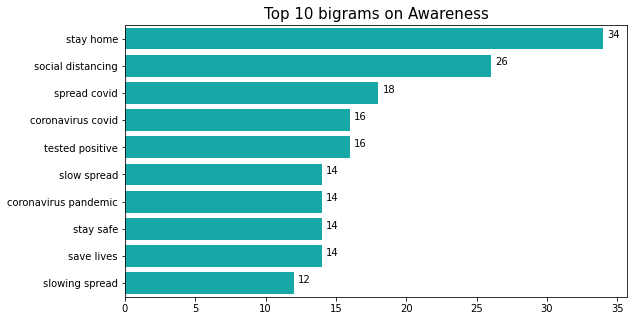

In [0]:
# Awareness label
wc_A = cvec_awareness_df.sum(axis = 0)
awareness_top10 = wc_A.sort_values(ascending=False).head(10)
bar_plot(awareness_top10.values, awareness_top10.index, 'Top 10 bigrams on Awareness','c') 

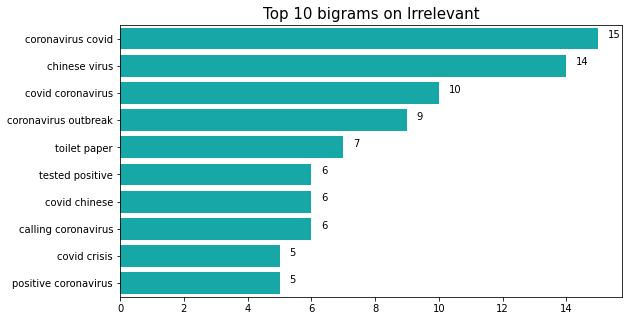

In [0]:
#Irrelevant label
wc_I = cvec_irrelevant_df.sum(axis = 0)
irrelevant_top10 = wc_I.sort_values(ascending=False).head(10)
bar_plot(irrelevant_top10.values, irrelevant_top10.index, 'Top 10 bigrams on Irrelevant','c')

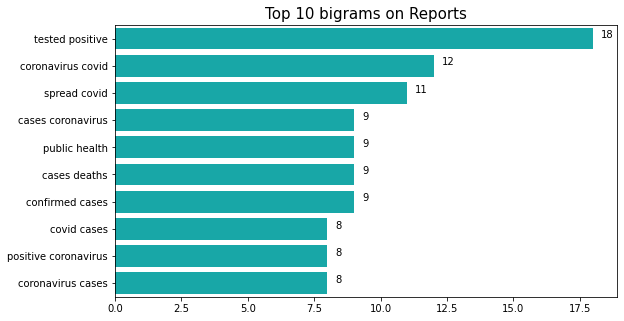

In [0]:
wc_R = cvec_report_df.sum(axis = 0)
report_top10 = wc_R.sort_values(ascending=False).head(10)
bar_plot(report_top10.values, report_top10.index, 'Top 10 bigrams on Reports','c')

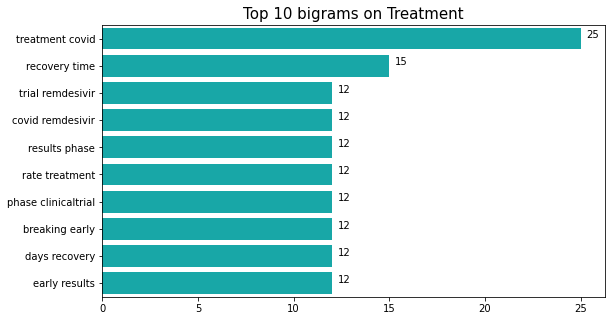

In [0]:
# Treatment label
wc_T = cvec_treatment_df.sum(axis = 0)
treatment_top10 = wc_T.sort_values(ascending=False).head(10)
bar_plot(treatment_top10.values, treatment_top10.index, 'Top 10 bigrams on Treatment','c')

###Common bigrams within the top 10 in each label

In [0]:
awareness_set = set(awareness_top10.index)
irrelevant_set = set(irrelevant_top10.index)
report_set = set(report_top10.index)
treatment_set = set(treatment_top10.index)
# Return common words
common_bigrams = awareness_set.intersection(irrelevant_set.intersection(report_set.intersection(treatment_set)))
common_bigrams

set()

### Create custom stop_words list to include common frequent words, since they occur frequently in all labels

In [0]:
custom = stop_words
custom = list(custom)
common_unigrams = list(common_unigrams)
common_bigrams = list(common_bigrams)

# Append unigrams to list 
for i in common_unigrams:
    custom.append(i)
    
# Append bigrams to list 
for i in common_bigrams:
    split_words = i.split(" ")
    for word in split_words:
        custom.append(word)

#Modelling

Conducting model-prep and using Pipeline and GridSearch to determine the most optimal model to run the data on. 

### Baseline Score

In [0]:
df['label'].value_counts(normalize=True)

1    0.323730
0    0.270660
2    0.216073
3    0.189538
Name: label, dtype: float64

### Setting X (predictor) and y (target) variables 

In [0]:
X = df['tweet']
y = df['label']

In [0]:
df['label'].unique()

array([0, 1, 2, 3])

### Train/Test Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=420,stratify=y,test_size = 0.1)

### Model 1: CountVectorizer & Logistic Regression 

In [0]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english', custom],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.1, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=10)
gs.fit(X_train, y_train);

y_pred = gs.predict(X_test)

print('Accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names = my_tags))

Accuracy 0.8409090909090909
              precision    recall  f1-score   support

   Awareness       0.86      0.89      0.88        36
  Irrelevant       0.76      0.86      0.80        43
      Report       0.81      0.61      0.69        28
   Treatment       1.00      1.00      1.00        25

    accuracy                           0.84       132
   macro avg       0.86      0.84      0.84       132
weighted avg       0.84      0.84      0.84       132



### Model 2: TfidfVectorize & Logistic Regression

In [0]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.1,1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train);
y_pred = gs.predict(X_test)

print('Accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names = my_tags))

Accuracy 0.8636363636363636
              precision    recall  f1-score   support

   Awareness       0.92      0.92      0.92        36
  Irrelevant       0.78      0.93      0.85        43
      Report       0.81      0.61      0.69        28
   Treatment       1.00      0.96      0.98        25

    accuracy                           0.86       132
   macro avg       0.88      0.85      0.86       132
weighted avg       0.87      0.86      0.86       132



###Representation of the best model using Confusion Matrix

In [0]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[33,  2,  1,  0],
       [ 1, 40,  2,  0],
       [ 2,  9, 17,  0],
       [ 0,  0,  1, 24]])

Text(0.5, 257.44, 'Predicted label')

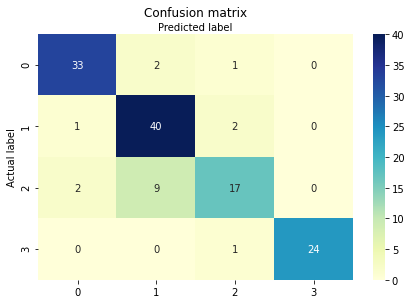

In [0]:
class_names=['Awareness','Irrelevant', 'Report', 'Treatment'] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Model 3: TfidfVectorizer & MultinomialNB 

In [0]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98],
               'tvect__min_df': [4, 5],
               'tvect__ngram_range': [(1,2), (1,3)],
               'nb__alpha': [0.3, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train);

y_pred = gs.predict(X_test)

print('Accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names = my_tags))

Accuracy 0.7575757575757576
              precision    recall  f1-score   support

   Awareness       0.90      0.75      0.82        36
  Irrelevant       0.67      0.86      0.76        43
      Report       0.59      0.57      0.58        28
   Treatment       1.00      0.80      0.89        25

    accuracy                           0.76       132
   macro avg       0.79      0.75      0.76       132
weighted avg       0.78      0.76      0.76       132



### Model 4: CountVectorizer & MultinomialNB 

In [0]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english', custom],
               'cvec__ngram_range': [(1,3)],
               'nb__alpha': [.4]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train);
y_pred = gs.predict(X_test)

print('Accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names = my_tags))

Accuracy 0.7954545454545454
              precision    recall  f1-score   support

   Awareness       0.80      0.97      0.88        36
  Irrelevant       0.81      0.67      0.73        43
      Report       0.64      0.57      0.60        28
   Treatment       0.93      1.00      0.96        25

    accuracy                           0.80       132
   macro avg       0.79      0.80      0.79       132
weighted avg       0.79      0.80      0.79       132



###Model 5: TfidVectoriser and SGDClassifier




In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='squared_loss', penalty='l2',alpha=1e-3, random_state=42, max_iter=10, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('Accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names = my_tags))

Accuracy 0.8257575757575758
              precision    recall  f1-score   support

   Awareness       0.85      0.92      0.88        36
  Irrelevant       0.80      0.81      0.80        43
      Report       0.70      0.57      0.63        28
   Treatment       0.96      1.00      0.98        25

    accuracy                           0.83       132
   macro avg       0.82      0.83      0.82       132
weighted avg       0.82      0.83      0.82       132



###Model 6: Keras Sequential


In [0]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(X_train) # only fit on train
X_train = tokenize.texts_to_matrix(X_train)
X_test = tokenize.texts_to_matrix(X_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
print(num_classes)
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 100
epochs = 25

model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mse', 'mae', 'mape', 'msle' ])
              
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

score = model.evaluate(X_test, y_test,
                       batch_size = batch_size, verbose=1)
print('Test Accuracy:', score[1])

Using TensorFlow backend.


4
Train on 949 samples, validate on 238 samples
Epoch 1/25
949/949 [==============================] - 0s 493us/step - loss: 1.3076 - accuracy: 0.3783 - mse: 0.1773 - mae: 0.3605 - mape: 180236640.0000 - msle: 0.0872 - val_loss: 1.1284 - val_accuracy: 0.6303 - val_mse: 0.1523 - val_mae: 0.3317 - val_mape: 165871552.0000 - val_msle: 0.0740
Epoch 2/25
949/949 [==============================] - 0s 128us/step - loss: 0.9921 - accuracy: 0.7218 - mse: 0.1324 - mae: 0.3040 - mape: 152006416.0000 - msle: 0.0640 - val_loss: 0.9024 - val_accuracy: 0.7689 - val_mse: 0.1185 - val_mae: 0.2827 - val_mape: 141366912.0000 - val_msle: 0.0571
Epoch 3/25
949/949 [==============================] - 0s 130us/step - loss: 0.7545 - accuracy: 0.8419 - mse: 0.0965 - mae: 0.2476 - mape: 123793896.0000 - msle: 0.0462 - val_loss: 0.7406 - val_accuracy: 0.8025 - val_mse: 0.0959 - val_mae: 0.2379 - val_mape: 118959248.0000 - val_msle: 0.0461
Epoch 4/25
949/949 [==============================] - 0s 126us/step - loss: 